# Minimization
Trying to get a hang of the `scipy.optimize.minimize` function, which I'll later use to find the best starting glacier surface area.

First I'll follow the examples from the official [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html). Thereafter I'll start to work with the glacier surface areas...

In [1]:
# import section
import numpy as np
from scipy.optimize import minimize, minimize_scalar

## Examples
In the first example I'll try to find a local minimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function).

In [ ]:
# define functions
def fct(x):
    return x**2

# define start values
x0 = 10
# run minimization
res = minimize(fct, x0, method='powell', options={'xtol': 1e-8, 'disp': True})
# show result
res.x

In [ ]:
# define function
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

# define start values
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
# find local minimum
res = minimize(rosen, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})
# see results
res.x

## Find starting surface area by miminization

In [2]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import minimize, minimize_scalar

# import the needed OGGM modules
import oggm
from oggm import cfg
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines
from oggm.core import vascaling

# ---------------------
#  PREPROCESSING TASKS
# ---------------------

# create test directory
testdir = os.path.join(get_test_dir(), 'tmp_comparison')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file
cfg.initialize()
cfg.set_intersects_db(get_demo_file('rgi_intersect_oetztal.shp'))
cfg.PATHS['working_dir'] = testdir
cfg.PATHS['dem_file'] = get_demo_file('hef_srtm.tif')
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
# use HistAlp as climate file
cfg.PATHS['climate_file'] = get_demo_file('histalp_merged_hef.nc')
# set hyper parameters for mass balance calibration
# cfg.PARAMS['baseline_y0'] = 1850
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI6.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

# compute the reference t* for the glacier
# given the reference of mass balance measurements
res = vascaling.t_star_from_refmb(gdir)
t_star, bias = res['t_star'], res['bias']

# --------------------
#  SCALING MODEL
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir, tstar=t_star, bias=bias)

# instance the mass balance models
ben_mbmod = vascaling.VAScalingMassBalance(gdir)

# get reference area
a0 = gdir.rgi_area_m2
# get reference year
rgi_df = get_rgi_glacier_entities([gdir.rgi_id])
y0 = int(rgi_df.BgnDate.values[0][:4])
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

# set up the glacier model with the values of 2003
hef_ref = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                   min_hgt=h0, max_hgt=h1,
                                   mb_model=ben_mbmod)

2019-02-14 13:36:59: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-02-14 13:36:59: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-02-14 13:36:59: oggm.core.gis: (RGI60-11.00897) glacier_masks
2019-02-14 13:37:00: oggm.core.climate: (RGI60-11.00897) process_custom_climate_data
2019-02-14 13:37:00: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-02-14 13:37:01: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-02-14 13:37:01: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2019-02-14 13:37:02: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2019-02-14 13:37:02: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-02-14 13:37:05: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-02-14 13:37:06: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-02-14 13:37:07: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


In [3]:
def to_minimize(area_m2_start, model_ref):
    """ Initialize VAS glacier model as copy of the reference model (model_ref)
    and adjust the model to the given starting area (area_m2_start) and
    starting year (1851). Let the model evolve to the same year as the
    reference model. Compute and return the relative absolute area error.

    :param area_m2_start: (float)
    :param model_ref: (oggm.VAScalingModel)
    :return: (float) relative absolute area error
    """
    # define model
    model_tmp = vascaling.VAScalingModel(year_0=model_ref.year_0,
                                         area_m2_0=model_ref.area_m2_0,
                                         min_hgt=model_ref.min_hgt_0,
                                         max_hgt=model_ref.max_hgt,
                                         mb_model=model_ref.mb_model)
    # scale to desired starting size
    model_tmp.create_start_glacier(area_m2_start)
    # run and compare, return relative error
    return np.abs(model_tmp.run_and_compare(model_ref))

In [30]:
# define bounds
area_m2_bounds = [100, 2*hef_ref.area_m2_0]
# run minimization
minimization_res = minimize_scalar(to_minimize, args=(hef_ref),
                                   bounds=area_m2_bounds,
                                   method='bounded')

minimization_res

     fun: 0.12043854803404441
 message: 'Solution found.'
    nfev: 32
  status: 0
 success: True
       x: 3134640.488672331

Try to visualize the start area seeking process...

In [44]:
# instance guessed starting areas
num = 15
area_guess = np.linspace(area_m2_bounds[0], area_m2_bounds[-1],  num, endpoint=True)
# create empty containers
iteration_list = list()
spec_mb_list = list()

# iterate over all starting areas
for area_ in area_guess:
    # instance iteration model
    model_guess = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                           min_hgt=h0, max_hgt=h1,
                                           mb_model=ben_mbmod)
    # set new starting values
    model_guess.create_start_glacier(area_)
    # run model and save years and area
    _years, _, _area, _, _spec_mb = model_guess.run_until(year_end=hef_ref.year)
    # create series and store in container
    iteration_list.append(pd.Series(_area, index=_years))
    spec_mb_list.append(pd.Series(_spec_mb, index=_years))

In [45]:
# set up model with resulted starting area
model = vascaling.VAScalingModel(year_0=hef_ref.year_0,
                                 area_m2_0=hef_ref.area_m2_0,
                                 min_hgt=hef_ref.min_hgt_0,
                                 max_hgt=hef_ref.max_hgt,
                                 mb_model=hef_ref.mb_model)
model.create_start_glacier(minimization_res.x)

# run
years, lenght, area, volume, spec_mb = model.run_until(year_end=hef_ref.year)

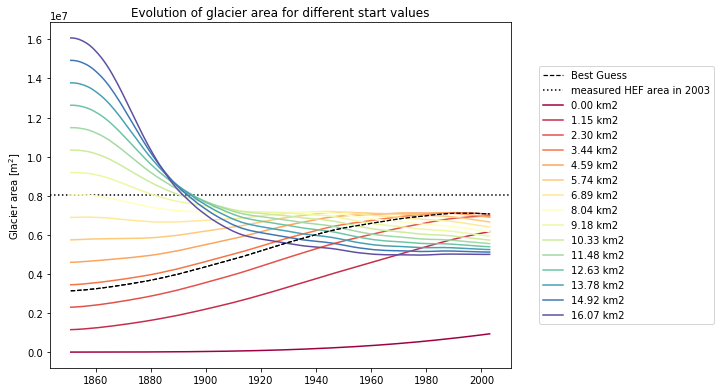

In [59]:
# create DataFrame
iteration_df = pd.DataFrame(iteration_list, index=['{:.2f}'.format(a/1e6) for a in area_guess])
iteration_df.index.name = 'Start Area [km$^2$]'

# visualize
import matplotlib.pyplot as plt
ax = plt.figure().add_axes([0.1,0.1,0.8,0.8])
ax.plot(years, area, color='k', ls='--', lw=1.2, label='Best Guess')
ax.axhline(hef_ref.area_m2_0, c='k', ls=':', label='measured HEF area in 2003')
iteration_df.T.plot(legend=False, figsize=[8,6], colormap='Spectral', ax=ax)
# legend
handels, labels = ax.get_legend_handles_labels()
labels[2:] = ['{} km2'.format(l) for l in labels[2:]]
ax.legend(handels, labels, bbox_to_anchor=(1.05, 0.5), loc=6)

# replot best guess estimate (in case it lies below another guess)
ax.plot(years, area, color='k', ls='--', lw=1.2, label='Best Guess')

ax.set_ylabel('Glacier area [m$^2$]')
ax.set_title('Evolution of glacier area for different start values');

In [47]:

labels

['Best Guess',
 'measured HEF area in 2003',
 '0.00 km2',
 '1.15 km2',
 '2.30 km2',
 '3.44 km2',
 '4.59 km2',
 '5.74 km2',
 '6.89 km2',
 '8.04 km2',
 '9.18 km2',
 '10.33 km2',
 '11.48 km2',
 '12.63 km2',
 '13.78 km2',
 '14.92 km2',
 '16.07 km2',
 'Best Guess km2']

In [ ]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd

# import the needed OGGM modules
import oggm
from oggm import cfg
from oggm.utils import get_demo_file, get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines
from oggm.core import vascaling

In [ ]:
# ---------------------
#  PREPROCESSING TASKS
# ---------------------

# create test directory
testdir = os.path.join(get_test_dir(), 'tmp_comparison')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file
cfg.initialize()
cfg.set_intersects_db(get_demo_file('rgi_intersect_oetztal.shp'))
cfg.PATHS['working_dir'] = testdir
cfg.PATHS['dem_file'] = get_demo_file('hef_srtm.tif')
cfg.PARAMS['border'] = 10
cfg.PARAMS['run_mb_calibration'] = True
cfg.PARAMS['baseline_climate'] = ''
cfg.PARAMS['use_multiprocessing'] = True
# use HistAlp as climate file
cfg.PATHS['climate_file'] = get_demo_file('histalp_merged_hef.nc')
# set hyper parameters for mass balance calibration
# cfg.PARAMS['baseline_y0'] = 1850
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI6.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

In [ ]:
# compute the reference t* for the glacier
# given the reference of mass balance measurements
res = vascaling.t_star_from_refmb(gdir)
t_star, bias = res['t_star'], res['bias']
print('t*: {}, bias: {}'.format(t_star, bias))

In [ ]:
# --------------------
#  SCALING MODEL
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir, tstar=t_star, bias=bias)

# instance the mass balance models
ben_mbmod = vascaling.VAScalingMassBalance(gdir)

# get reference area
a0 = gdir.rgi_area_m2
# get reference year
rgi_df = get_rgi_glacier_entities([gdir.rgi_id])
y0 = int(rgi_df.BgnDate.values[0][:4])
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

# set up the glacier model with the values of 2003
model_ref = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=ben_mbmod)

In [ ]:
from scipy.optimize import minimize

def run_and_compare(area_m2_start, y_start, model_ref):
    """ Instance a new VAS model with the given starting area (`area_m2_start`)
    at the beginning of the model integration (`y_start`). The model runs and compares
    the fina area with the given reference model.
    """
    # instance iteration model
    model_guess = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                           min_hgt=h0, max_hgt=h1,
                                           mb_model=ben_mbmod)
    # set new starting values
    model_guess.create_start_glacier(area_m2_start, year_start=y_start)
    # run model and save years and area
    _years, _, _area, _, _spec_mb = model_guess.run_until(year_end=model_ref.year, reset=True)
    # compute relative difference to measured area
    a_dif = (1 - _area[-1]/6e6)
    
    return a_dif

In [ ]:
# run minimization
res = minimize(run_and_compare, x0=2e7, args=(1851, model_ref), method='powell')
res

In [ ]:
# instance iteration model
model_guess = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                       min_hgt=h0, max_hgt=h1,
                                       mb_model=ben_mbmod)
# set new starting values
model_guess.create_start_glacier(float(res.x), year_start=1851)
# run model and save years and area
_years, _, _area, _, _spec_mb = model_guess.run_until(year_end=model_ref.year, reset=True)
plt.plot(_years, _area)
plt.axhline(6e6)
# compute relative difference to measured area
a_dif = abs(_area[-1] - a0)
a_dif

In [ ]:
# get value
area_m2_start = float(res.x)
print('Start area: {:.2f} km2'.format(area_m2_start/1e6))

In [ ]:
print(area[-1])
print(a0)

In [ ]:
abs(1-area[-1]/a0)

In [ ]:
import importlib
importlib.reload(vascaling)

In [ ]:
# instance first guess areas
a_min = 0.1
a_max = a0*2e-6
num = 20
area_guess = np.linspace(a_min, a_max, num, endpoint=True)*1e6
#area_guess = [model_ref.area_m2_0]
iteration_list = list()
spec_mb_list = list()

# iterate over all starting areas
for area_ in area_guess:
    # instance iteration model
    model_guess = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                           min_hgt=h0, max_hgt=h1,
                                           mb_model=ben_mbmod)
    # set new starting values
    model_guess.create_start_glacier(area_)
    # run model and save years and area
    _years, _, _area, _, _spec_mb = model_guess.run_until(year_end=model_ref.year)
    # create series and store in container
    iteration_list.append(pd.Series(_area, index=_years))
    spec_mb_list.append(pd.Series(_spec_mb, index=_years))

In [ ]:
# set up model with resulted starting area
model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                 min_hgt=h0, max_hgt=h1,
                                 mb_model=ben_mbmod)
model.create_start_glacier(3134747.2611997463)

# run
years, lenght, area, volume, spec_mb = model.run_until(2003)

In [ ]:
# create DataFrame
iteration_df = pd.DataFrame(iteration_list, index=['{:.2f}'.format(a/1e6) for a in area_guess])
iteration_df.index.name = 'Start Area [km$^2$]'

# visualize
import matplotlib.pyplot as plt
ax = iteration_df.T.plot(legend=False, figsize=[8,6], colormap='Spectral')
ax.plot(years, area, color='k', ls='--', lw=1.2)
ax.axhline(8e6, c='k', ls=':', label='measured HEF area in 2003')
ax.set_ylabel('Glacier area [m$^2$]')
ax.set_title('Evolution of glacier area for different start values');